## Load in vivo data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
from tqdm import tqdm

from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp
import cell_inference.utils.feature_extractors.SummaryStats2D as ss2
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
from cell_inference.utils.transform.data_transform import log_modulus

%matplotlib inline

invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikeWaveforms_NP_SUTempFilter_NPExample'
# invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikes_NPUnits_large.h5'

INVIVO_PATH = 'cell_inference/resources/invivo'
DATA_PATH = os.path.join(INVIVO_PATH, invivo_name + '.h5')
LFP_PATH = os.path.join(INVIVO_PATH, 'lfp_' + invivo_name + '.npz')  # LFP and labels
STATS_PATH = os.path.join(INVIVO_PATH, 'summ_stats_' + invivo_name + '.npz')  # summary statistics

save_lfp = False
save_stats = False

In [2]:
with h5py.File(DATA_PATH,'r') as hf:
    elec_pos = hf['coord'][()]
    lfp = 1e-3 * hf['data'][()].transpose((0,2,1)) # (samples x channels x time) -> (samples x time x channels), uV -> mV
    IDs = hf['ID'][()]
    if 'layer' in hf:
        layer_type = {i[0]: name for name, i in hf['layer'].attrs.items()}
        layer = np.array([layer_type[i] for i in hf['layer']])
    else:
        layer = np.full(lfp.shape[0], 'N/A')

## Process LFP

In [3]:
if save_lfp or save_stats:
    pad_spike_window = False
    bad_cases = tuple(range(-1,3)) if pad_spike_window else tuple(range(3))

    bad_indices = {bad: [] for bad in bad_cases}
    lfp_list = []
    coord = []
    ycenter = []
    summ_stats = []

    for i in tqdm(range(lfp.shape[0])):
        bad, g_lfp, _, g_coords, y_c, _, ss = process_lfp(
            lfp[i], coord=elec_pos, dt=None, gauss_filt=True,
            calc_summ_stats=save_stats, additional_stats=3, err_msg=True
        )
        bad_indices[bad].append(i)
        if bad<=0:
            lfp_list.append(g_lfp)
            coord.append(g_coords)
            ycenter.append(y_c)
            if save_stats:
                summ_stats.append(ss)

    t = params.DT * np.arange(params.WINDOW_SIZE)
    windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)
    coord = np.stack(coord, axis=0)
    ycenter = np.array(ycenter)
    summ_stats = np.array(summ_stats)

    bad_idx = np.array([i for bad, indices in bad_indices.items() if bad>0 for i in indices])
    good_indices = np.sort([i for bad, indices in bad_indices.items() if bad<=0 for i in indices])
    print('%d good samples out of %d samples.' % (good_indices.size, lfp.shape[0]))
    for bad, indices in bad_indices.items():
        print('Bad case %d bad: %d samples.' % (bad, len(indices)))

## Save results

In [4]:
if save_lfp:
    np.savez(LFP_PATH, t=t, x=windowed_lfp, coord=coord, yc=ycenter, layer=layer,
             bad_indices=bad_indices, good_indices=good_indices)
if save_stats:
    np.savez(STATS_PATH, x=summ_stats, yc=ycenter, layer=layer[good_indices])

## Check LFP amplitude decay of all cells

In [5]:
lfp_list = np.load(LFP_PATH)['x']
summ_stats = np.load(STATS_PATH)['x']
layer = np.load(STATS_PATH)['layer']
good_indices = np.load(LFP_PATH)['good_indices']
ycenter =  np.load(STATS_PATH)['yc']
ids = IDs[good_indices]

layer_idx = {L: np.nonzero(layer==L)[0] for L in np.unique(layer)}
sort_idx = np.argsort(np.array([idx.size for idx in layer_idx.values()]))
layer_idx = dict(zip(np.asarray(list(layer_idx.keys()))[sort_idx], np.asarray(list(layer_idx.values()), dtype=object)[sort_idx]))
layer_clr = ['darkcyan', 'darkred', 'goldenrod']
layer_clr_light = ['lightcyan', 'mistyrose', 'lemonchiffon']
layer_names = list(layer_idx.keys())

dy = ss2.DY
decay_stats = dy * summ_stats[:, 48:56]
decay_name = np.array(['tr_lambda_l', 'tr_lambda_r', 'tr_slope_l', 'tr_slope_r',
                       'pk_lambda_l', 'pk_lambda_r', 'pk_slope_l', 'pk_slope_r'])
decay_dict = {name: decay_stats[:, i] for i, name in enumerate(decay_name)}
df_decay = pd.DataFrame(decay_dict, index=ids)
df_decay['layer'] = layer

 #### Check decay of LFP magnitude of all cells

In [6]:
grid_shape = (ss2.GRID_SHAPE[0], int(lfp_list.shape[2]/ss2.GRID_SHAPE[0]))
def get_relative_decay(lfp, relative=True, bound=7.0):
    t_t, t_p, troughs, peaks = ss2.get_tr_pk(lfp)
    y_troughs = ss2.get_max_val_y(troughs, grid_shape)
    y_peaks = ss2.get_max_val_y(peaks, grid_shape)
    if relative:
        tr_max = np.log(np.amax(y_troughs))
        pk_max = np.log(np.amax(y_peaks))
        y_troughs = np.log(np.fmax(y_troughs, np.exp((tr_max - bound)))) - tr_max
        y_peaks = np.log(np.fmax(y_peaks, np.exp((pk_max - bound)))) - pk_max
    return t_t, t_p, y_troughs, y_peaks

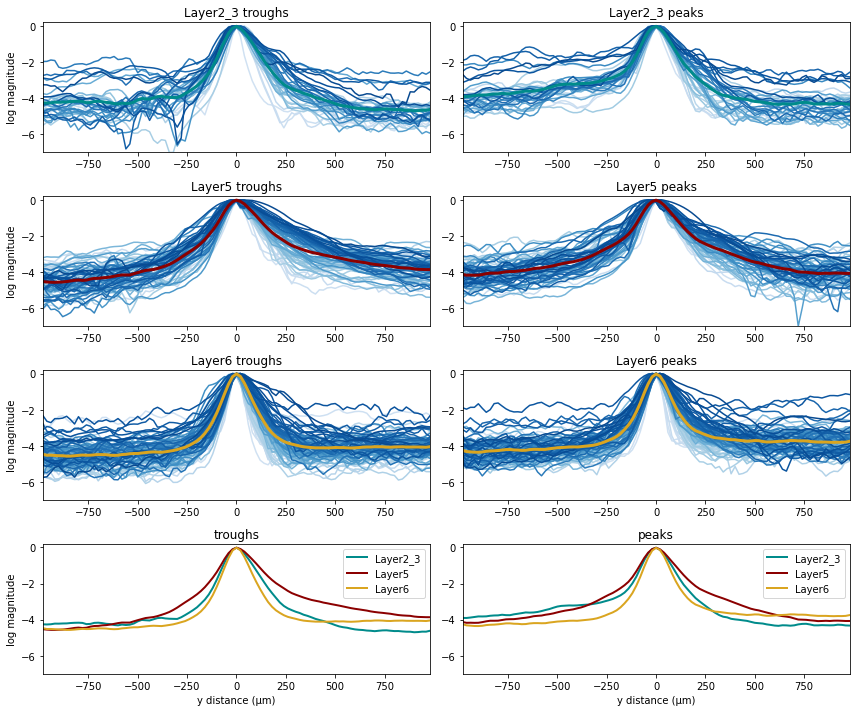

In [7]:
y_trouhgs_list = np.empty((lfp_list.shape[0], grid_shape[1]))
y_peaks_list = np.empty((lfp_list.shape[0], grid_shape[1]))
for i, lfp in enumerate(lfp_list):
    _, _, y_troughs, y_peaks = get_relative_decay(lfp)
    y_trouhgs_list[i] = y_troughs
    y_peaks_list[i] = y_peaks

rel_y = dy * ss2.REL_IDX
n_layer = len(layer_idx)
sort_name = 'lambda_r'
mm = min(np.amin(y_trouhgs_list), np.amin(y_peaks_list))

plt.figure(figsize=(12, 10))
for i, (L, idx) in enumerate(layer_idx.items()):
    y_troughs_m = np.mean(y_trouhgs_list[idx], axis=0)
    y_peaks_m = np.mean(y_peaks_list[idx], axis=0)
    
    cycler = plt.cycler('color', plt.cm.Blues(np.linspace(0.2, .9, len(idx))))
    plt.subplot(n_layer + 1, 2, i * 2 + 1)
    plt.gca().set_prop_cycle(cycler)
    sort_idx = np.argsort(decay_dict['tr_' + sort_name][idx])
    plt.plot(rel_y, y_trouhgs_list[idx[sort_idx]].T)
    plt.plot(rel_y, y_troughs_m, color=layer_clr[i], linewidth=3)
    plt.xlim(rel_y[[0, -1]])
    plt.ylim([mm, 0.2])
    plt.title(L + ' troughs')
    plt.ylabel('log magnitude')
    
    plt.subplot(n_layer + 1, 2, i * 2 + 2)
    plt.gca().set_prop_cycle(cycler)
    sort_idx = np.argsort(decay_dict['pk_' + sort_name][idx])
    plt.plot(rel_y, y_peaks_list[idx[sort_idx]].T)
    plt.plot(rel_y, y_peaks_m, color=layer_clr[i], linewidth=3)
    plt.xlim(rel_y[[0, -1]])
    plt.ylim([mm, 0.2])
    plt.title(L + ' peaks')
    
    plt.subplot(n_layer + 1, 2, n_layer * 2 + 1)
    plt.plot(rel_y, y_troughs_m, color=layer_clr[i], linewidth=2, label=L)
    plt.xlim(rel_y[[0, -1]])
    plt.ylim([mm, 0.2])
    plt.title('troughs')
    plt.ylabel('log magnitude')
    plt.xlabel('y distance (μm)')
    plt.legend()
    
    plt.subplot(n_layer + 1, 2, n_layer * 2 + 2)
    plt.plot(rel_y, y_peaks_m, color=layer_clr[i], linewidth=2, label=L)
    plt.xlim(rel_y[[0, -1]])
    plt.ylim([mm, 0.2])
    plt.title('peaks')
    plt.xlabel('y distance (μm)')
    plt.legend()
plt.tight_layout()
plt.show()

#### Distributions of decay length constant

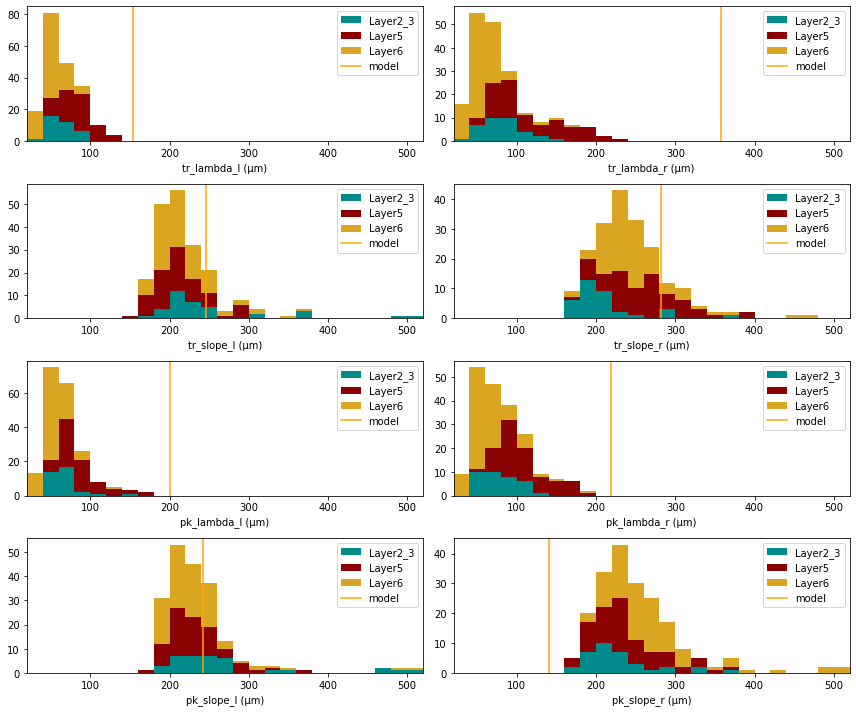

In [8]:
bin_max = 25
bin_min = int(np.floor(np.amin(decay_stats) / dy))
bins = np.append(dy * np.arange(bin_min, bin_max), np.amax(decay_stats))

# Soma gmax 0.011, Tuft gmax 0.11
example_decay = '[154.16563175 357.69783934 246.1733949 282.27949884 201.04731236 218.94985076 242.48060098 140.]'

example_decay = np.array(eval(example_decay.replace(' ', ','))).ravel()

plt.figure(figsize=(12, 10))
for i, name in enumerate(decay_name):
    plt.subplot(int(decay_name.size / 2), 2, i + 1)
    plt.hist([decay_dict[name][idx] for idx in layer_idx.values()], bins=bins, label=layer_names, color=layer_clr, stacked=True)
    plt.axvline(x=example_decay[i], color='orange', label='model')
    plt.xlim([bins[0], bins[-2] + bins[2] - bins[0]])
    plt.xlabel(name + ' (μm)')
    plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# sort by selected feature
df_decay = df_decay.sort_values('tr_lambda_r')
# pd.set_option('display.max_rows', None)
display(df_decay)
print(np.amin(decay_stats, axis=0))
print(np.amax(decay_stats, axis=0))

,tr_lambda_l,tr_lambda_r,tr_slope_l,tr_slope_r,pk_lambda_l,pk_lambda_r,pk_slope_l,pk_slope_r,layer
88,34.170655,22.646796,184.302964,233.942021,47.212750,22.225437,209.744051,316.186941,Layer6
404,26.745031,25.473751,367.692889,462.826361,26.999876,24.972158,281.610306,364.421917,Layer6
503,34.730996,27.430634,247.250319,289.595246,32.020161,31.652860,214.285662,256.057290,Layer6
334,30.771208,28.506955,218.043799,176.377580,45.939435,41.787090,249.958637,238.995386,Layer2_3
104,40.896709,29.432450,222.895790,220.082695,41.797009,33.111336,229.824622,276.633745,Layer6
...,...,...,...,...,...,...,...,...,...
252,133.103410,189.401941,232.786399,262.808087,177.365973,144.137216,249.597850,247.828574,Layer5
226,104.520240,189.960352,214.970992,263.354469,81.989258,170.247735,231.466671,241.228926,Layer5
460,75.174445,201.519109,209.456543,264.886352,77.772569,167.712403,205.457288,239.995993,Layer5
248,90.381732,205.405839,199.125088,226.626877,84.693167,164.736765,201.342902,213.464526,Layer5


[ 26.74503074  22.64679572 152.77052727 168.02520026  26.95812308
  21.09615842 171.51489246 173.3829504 ]
[133.98788101 226.68685367 529.44416294 462.82636057 177.36597304
 187.34555028 548.85744657 775.77970222]


#### Point coordinates representation of the fit two-segment lines (w1, w2, y2)

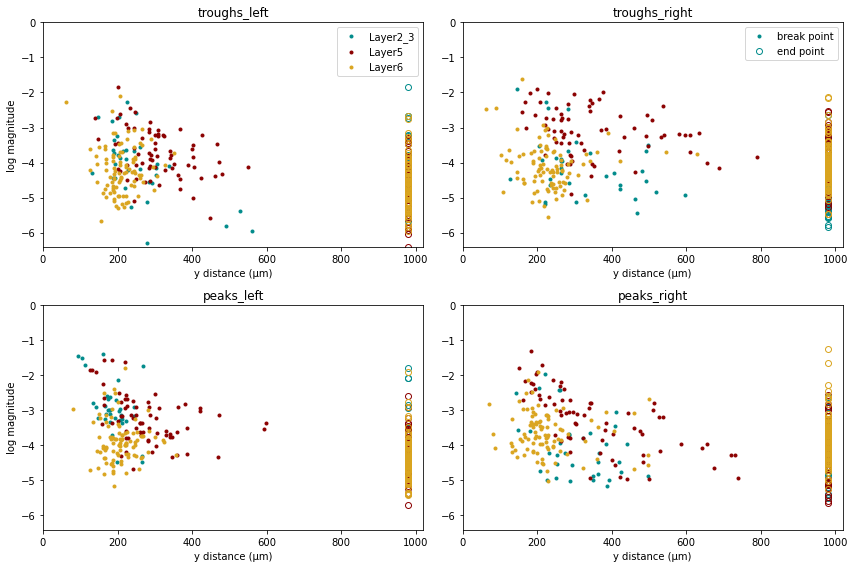

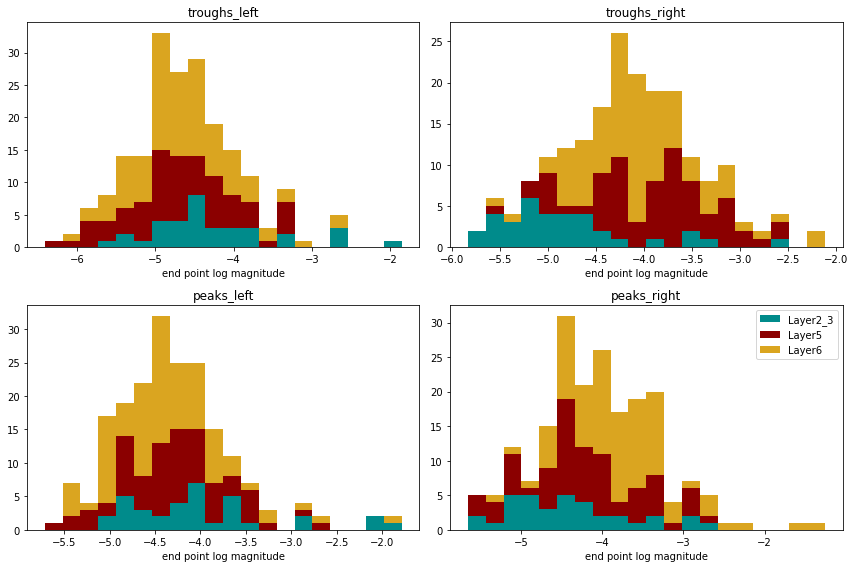

In [10]:
y2 = np.floor(params.Y_WINDOW_SIZE / 2 / dy) * dy
fit_pts = summ_stats[:, 56:68].copy().reshape((-1, 4, 3))
fit_pts *= [-1, -1, dy]
w_min = np.amin(fit_pts[:, :, :2])
fit_pts_name = ['troughs_left', 'troughs_right', 'peaks_left', 'peaks_right']

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    for j, (L, idx) in enumerate(layer_idx.items()):
        if i==0:
            label = (L, None)
        elif i==1 and j==0:
            label = ('break point', 'end point')
        else:
            label = (None, None)
        plt.plot(fit_pts[idx, i, 2], fit_pts[idx, i, 0], color=layer_clr[j], label=label[0], linestyle='None', marker='.')
        plt.plot(y2 + np.zeros(idx.size), fit_pts[idx, i, 1], color=layer_clr[j], label=label[1], linestyle='None', marker='o', fillstyle='none')
    plt.xlim([0, y2 + 2 * dy])
    plt.ylim([w_min, 0])
    plt.xlabel('y distance (μm)')
    if not i % 2: plt.ylabel('log magnitude')
    plt.title(fit_pts_name[i])
    if i<= 1:
        plt.legend()
plt.tight_layout()

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist([fit_pts[idx, i, 1] for idx in layer_idx.values()], bins=20, label=layer_names, color=layer_clr, stacked=True)
    plt.xlabel('end point log magnitude')
    plt.title(fit_pts_name[i])
plt.legend()
plt.tight_layout()

plt.show()

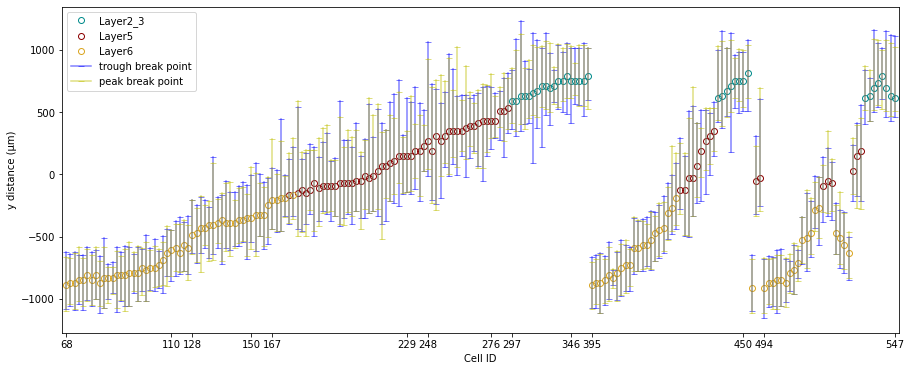

In [11]:
y1_range = ycenter.reshape((-1, 1)) + fit_pts[:, :, 2] * np.array((-1, 1, -1, 1))
x = np.arange(ids.size)
tick_idx = (np.nonzero(np.diff(ids) > 8)[0].reshape((-1, 1)) + np.array((-4, 1))).ravel()
tick_idx = np.hstack((0, tick_idx, ids.size - 1))

plt.figure(figsize=(15, 6))
for i, (L, idx) in enumerate(layer_idx.items()):
    plt.plot(x[idx], ycenter[idx], color=layer_clr[i], label=L, linestyle='None', marker='o', fillstyle='none')
label = (None, None)
for i in range(x.size):
    if i == x.size-1:
        label = ('trough break point', 'peak break point')
    plt.plot(x[i] * np.ones(2), y1_range[i, :2], label=label[0], marker='_', color='b', alpha=0.5)
    plt.plot(x[i] * np.ones(2), y1_range[i, 2:], label=label[1], marker='_', color='y', alpha=0.5)
plt.xlim(x[0] - 1, x[-1] + 1)
ax = plt.gca()
ax.set_xticks(tick_idx)
ax.set_xticklabels(ids[tick_idx])
plt.xlabel('Cell ID')
plt.ylabel('y distance (μm)')
plt.legend()
plt.show()

#### Maximum magnitude distribution

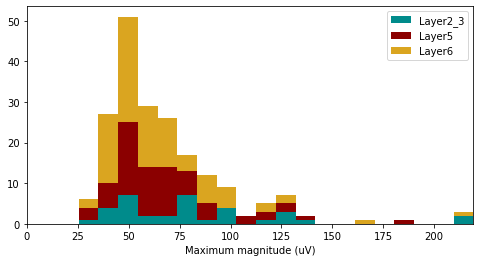

In [12]:
max_mag = np.amax(summ_stats[:, [33, 38]], axis=1)

plt.figure(figsize=(8, 4))
_, bins, _ = plt.hist([max_mag[idx] for idx in layer_idx.values()], bins=20, label=layer_names, color=layer_clr, stacked=True)
plt.xlim([0, bins[-1]])
plt.xlabel('Maximum magnitude (uV)')
plt.legend()
plt.show()

#### Plot distribution of averaged magnitude in neighbor volume of the break point

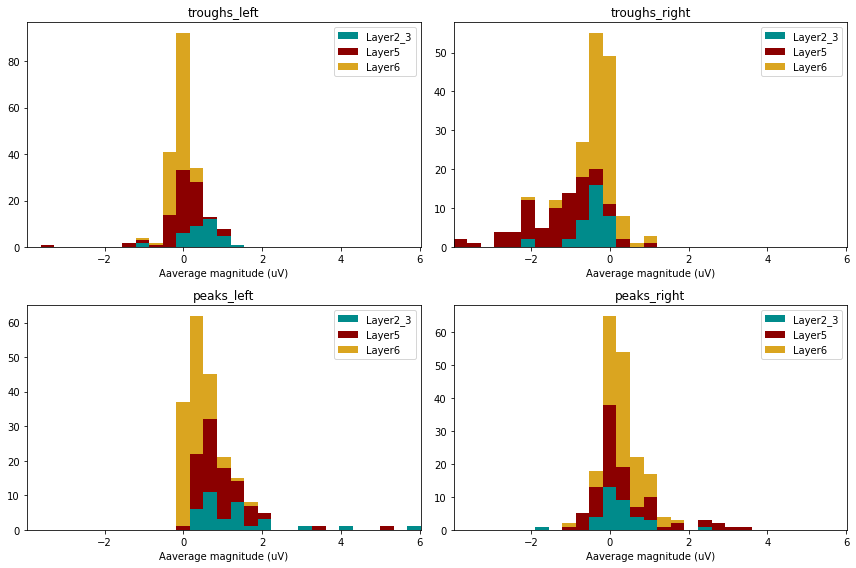

In [13]:
relative_magnitude = False
vol_avg = summ_stats[:, 68:72].copy()
if not relative_magnitude:
    vol_avg *= max_mag.reshape((-1, 1))
bins = np.linspace(np.amin(vol_avg), np.amax(vol_avg), 30)

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist([vol_avg[idx, i] for idx in layer_idx.values()], bins=bins, label=layer_names, color=layer_clr, stacked=True)
    plt.xlim(bins[[0, -1]])
    if relative_magnitude:
        plt.xlabel('Relative average magnitude')
    else:
        plt.xlabel('Aaverage magnitude (uV)')
    plt.title(fit_pts_name[i])
    plt.legend()
plt.tight_layout()
plt.show()

#### Average LFP at the tuft

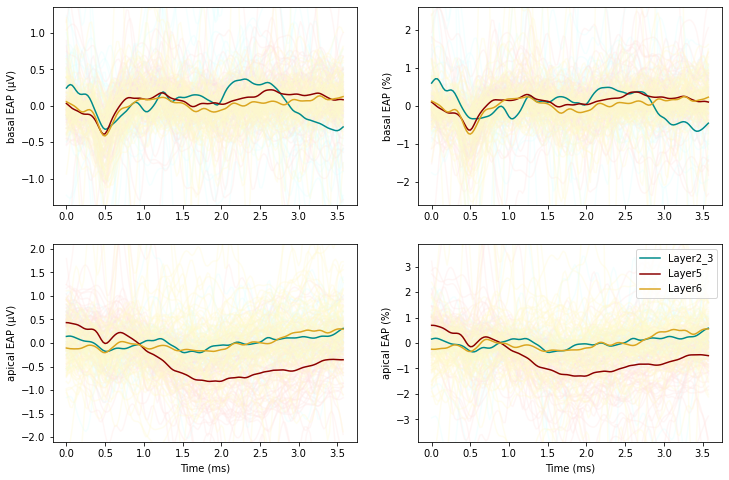

In [14]:
t = np.load(LFP_PATH)['t']
basal_lfp = 1000 * np.mean(lfp_list.reshape(lfp_list.shape[:2] + (ss2.GRID_SHAPE[0], ss2.NY))[:,:,:,0], axis=2)
apical_lfp = 1000 * np.mean(lfp_list.reshape(lfp_list.shape[:2] + (ss2.GRID_SHAPE[0], ss2.NY))[:,:,:,-1], axis=2)
n_sigma = 3

_, ax = plt.subplots(2, 2, figsize=(12, 8))
for j, (L, idx) in enumerate(layer_idx.items()):
    for i in idx:
        ax[0, 0].plot(t, basal_lfp[i, :], color=layer_clr_light[j], alpha=0.3)
        ax[1, 0].plot(t, apical_lfp[i, :], color=layer_clr_light[j], alpha=0.3)
for j, (L, idx) in enumerate(layer_idx.items()):
    ax[0, 0].plot(t, np.mean(basal_lfp[idx, :], axis=0), color=layer_clr[j], label=L)
    ax[1, 0].plot(t, np.mean(apical_lfp[idx, :], axis=0), color=layer_clr[j], label=L)
plt.subplot(221)
plt.ylabel('basal EAP (μV)')
plt.ylim(n_sigma * np.std(basal_lfp) * np.array([-1, 1]))
plt.subplot(223)
plt.ylabel('apical EAP (μV)')
plt.ylim(n_sigma * np.std(apical_lfp) * np.array([-1, 1]))
plt.xlabel('Time (ms)')

basal_lfp *= 100 / max_mag.reshape((-1, 1))
apical_lfp *= 100 / max_mag.reshape((-1, 1))
for j, (L, idx) in enumerate(layer_idx.items()):
    for i in idx:
        ax[0, 1].plot(t, basal_lfp[i, :], color=layer_clr_light[j], alpha=0.3)
        ax[1, 1].plot(t, apical_lfp[i, :], color=layer_clr_light[j], alpha=0.3)
for j, (L, idx) in enumerate(layer_idx.items()):
    ax[0, 1].plot(t, np.mean(basal_lfp[idx, :], axis=0), color=layer_clr[j], label=L)
    ax[1, 1].plot(t, np.mean(apical_lfp[idx, :], axis=0), color=layer_clr[j], label=L)
plt.subplot(222)
plt.ylabel('basal EAP (%)')
plt.ylim(n_sigma * np.std(basal_lfp) * np.array([-1, 1]))
plt.subplot(224)
plt.ylabel('apical EAP (%)')
plt.ylim(n_sigma * np.std(apical_lfp) * np.array([-1, 1]))
plt.xlabel('Time (ms)')

plt.legend(loc=1)
plt.show()

#### Spike width

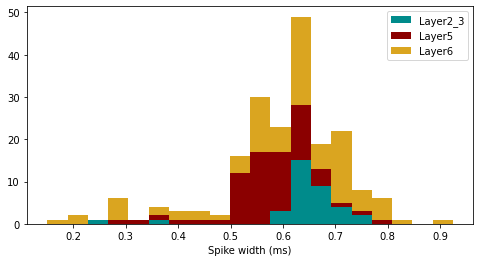

In [15]:
spike_width = params.DT * (summ_stats[:, 41] - summ_stats[:, 39])  # t2 - t0
plt.figure(figsize=(8, 4))
_, bins, _ = plt.hist([spike_width[idx] for idx in layer_idx.values()], bins=20, label=layer_names, color=layer_clr, stacked=True)
plt.xlabel('Spike width (ms)')
plt.legend()
plt.show()

## Check decay of LFP magnitude of selected cell and plot its LFP

In [16]:
select_ID = 531 # 214, 251, 281, 227
select_id = np.nonzero(ids==select_ID)[0][0]

lfp = 1000 * lfp_list[select_id]  # mV -> uV
t = np.load(LFP_PATH)['t']
coords = np.load(LFP_PATH)['coord'][select_id]
print(layer[select_id])

Layer5


#### Check LFP at the tuft

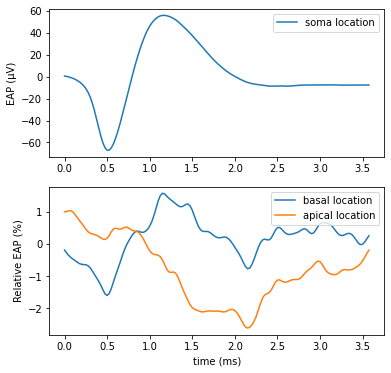

In [17]:
max_mag_elec = np.amax(np.abs(lfp), axis=0)
max_mag_idx = np.argmax(max_mag_elec, axis=0)
lfp_soma = lfp[:, max_mag_idx]
plt.figure(figsize=(6, 6))
plt.subplot(211)
plt.plot(t, lfp_soma, label='soma location')
plt.ylabel('EAP (μV)')
plt.legend(loc=1)
plt.subplot(212)
plt.plot(t, basal_lfp[select_id, :], label='basal location')
plt.plot(t, apical_lfp[select_id, :], label='apical location')
plt.ylabel('Relative EAP (%)')
plt.legend(loc=1)
plt.xlabel('time (ms)')
plt.show()

#### Check decay of LFP magnitude

In [18]:
t_t, t_p, y_troughs, y_peaks = get_relative_decay(lfp, relative=False)
lambda_troughs, pts_troughs, tr_max_idx = ss2.get_decay(y_troughs)
lambda_peaks, pts_peaks, pk_max_idx = ss2.get_decay(y_peaks)
# fit lines
l_troughs, brk_pts_trough = ss2.get_fit(y_troughs, pts_troughs)
l_peaks, brk_pts_peak = ss2.get_fit(y_peaks, pts_peaks)
for i in range(2):
    pts_troughs[i][2] *= dy
    pts_peaks[i][2] *= dy

np.set_printoptions(suppress=True)
print('Length constant (um) of troughs / peaks: \n  by lambda (left, right), by slope (left, right)')
print(dy * np.array([lambda_troughs, lambda_peaks]))
print('(y1, y2, x1) of two-line-segenmts (left, right) of troughs / peaks:')
print(pts_troughs)
print(pts_peaks)

Length constant (um) of troughs / peaks: 
  by lambda (left, right), by slope (left, right)
[[114.90130905 167.6592108  227.91032154 282.59051601]
 [150.91238974 119.72153447 241.65142954 225.06196649]]
(y1, y2, x1) of two-line-segenmts (left, right) of troughs / peaks:
[array([  3.50278007,   4.29993689, 402.47401582]), array([  2.18655333,   3.46791539, 366.59580574])]
[array([  3.12958095,   4.05542811, 472.29253931]), array([  2.20340069,   4.35435634, 263.79451164])]


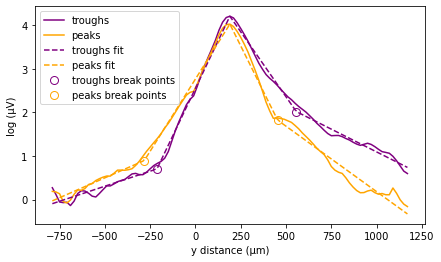

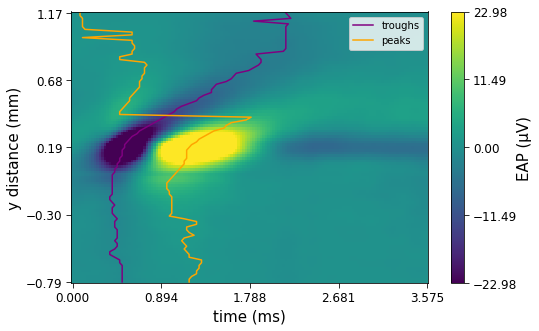

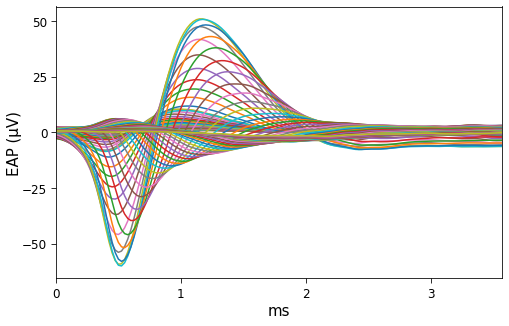

In [19]:
ix = 1
fontsize = 15
labelpad = 0
ticksize = 12
tick_length = 5
nbins = 5

x_dist = np.unique(coords[:, 0])
e_idx = coords[:, 0]==x_dist[ix]

def interp1(y, x):
    x = np.asarray(x)
    y = np.asarray(y)
    i = x.astype(int)
    return y[i] + (x - i) * (y[i + 1] - y[i])

plt.figure(figsize=(7, 4))
plt.plot(coords[e_idx, 1], np.log(y_troughs), color='purple', label='troughs')
plt.plot(coords[e_idx, 1], np.log(y_peaks), color='orange', label='peaks')
plt.plot(coords[e_idx, 1], l_troughs, color='purple', linestyle='--', label='troughs fit')
plt.plot(coords[e_idx, 1], l_peaks, color='orange', linestyle='--', label='peaks fit')
plt.plot(interp1(coords[e_idx, 1], brk_pts_trough[0]), brk_pts_trough[1], color='purple',
         linestyle='none', marker='o', markerfacecolor='none', markersize=8, label='troughs break points')
plt.plot(interp1(coords[e_idx, 1], brk_pts_peak[0]), brk_pts_peak[1], color='orange',
         linestyle='none', marker='o', markerfacecolor='none', markersize=8, label='peaks break points')
plt.xlabel('y distance (μm)')
plt.ylabel('log (μV)')
plt.legend()

plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=coords[e_idx, 1], lfp=lfp[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', colorbar_label='EAP (μV)', axes=plt.gca())
plt.plot(t[t_t[e_idx]], coords[e_idx, 1]/1000, color='purple', label='troughs')
plt.plot(t[t_p[e_idx]], coords[e_idx, 1]/1000, color='orange', label='peaks')
plt.legend()
plt.ylabel('y distance (mm)')

plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp[:, e_idx], # electrodes=coords[e_idx, :],
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.gca().set_ylabel('EAP (μV)')
plt.show()

#### Apply log modulus transform to see small magnitude features

In [20]:
n_fold = 30
max_logmod = np.ceil(np.log2(n_fold))  # max value after transform
n_fold = 2**max_logmod - 1
ref_mag = np.amax(np.abs(lfp)) / n_fold
print('Maximum magnitude is %d-fold reference magnitude %.3g μV.' % (n_fold, ref_mag))
lfp_logmod = log_modulus(lfp, ref_mag)

Maximum magnitude is 31-fold reference magnitude 2.16 μV.


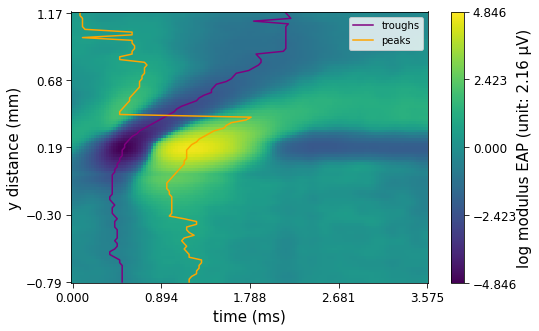

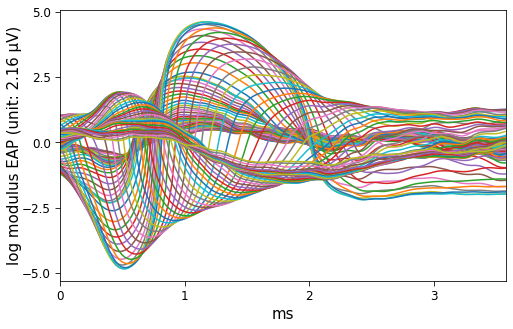

In [21]:
lfp_label = 'log modulus EAP (unit: %.3g μV)' % (ref_mag)

plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=coords[e_idx, 1], lfp=lfp_logmod[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='max', colorbar_label=lfp_label, axes=plt.gca())
plt.plot(t[t_t[e_idx]], coords[e_idx, 1]/1000, color='purple', label='troughs')
plt.plot(t[t_p[e_idx]], coords[e_idx, 1]/1000, color='orange', label='peaks')
plt.legend()
plt.ylabel('y distance (mm)')

plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp_logmod[:, e_idx], # electrodes=coords[e_idx, :], vlim='max',
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.gca().set_ylabel(lfp_label)

plt.show()

## Save figures to files

In [29]:
t = np.load(LFP_PATH)['t']
coord = np.load(LFP_PATH)['coord']

select_ID = IDs[0]

select_id = np.nonzero(ids==select_ID)[0][0]
cell_name = 'Cell' + str(select_ID) + '_' + layer[select_id]

lfp = 1000 * lfp_list[select_id]  # mV -> uV
coords = coord[select_id]

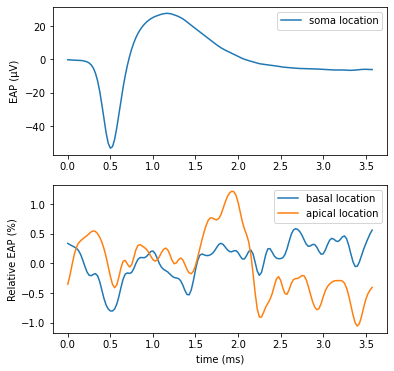

In [30]:
max_mag_elec = np.amax(np.abs(lfp), axis=0)
max_mag_idx = np.argmax(max_mag_elec, axis=0)
lfp_soma = lfp[:, max_mag_idx]

plt.figure(figsize=(6, 6))
plt.subplot(211)
plt.plot(t, lfp_soma, label='soma location')
plt.ylabel('EAP (μV)')
plt.legend(loc=1)
plt.subplot(212)
plt.plot(t, basal_lfp[select_id, :], label='basal location')
plt.plot(t, apical_lfp[select_id, :], label='apical location')
plt.ylabel('Relative EAP (%)')
plt.legend(loc=1)
plt.xlabel('time (ms)')
plt.show()